In [ ]:
! pip install imbalanced-learn

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    balanced_accuracy_score, roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [ ]:
batch_size = 128
test_val_size = 0.2
lambda_weight = 1.0
num_epochs = 40
lr = 1e-3
weight_decay = 1e-4
patience = 6
clip_norm = 1.0
SEED = 23
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# transformation

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/SUMMER_RESEARCH/Data/imputed_data.csv')
if 'egoid' in data.columns:
    data = data.drop(columns='egoid')

tasks = ['target_depression', 'target_anxiety', 'target_sleep']
X_df = data.drop(columns=tasks)
y_df = data[tasks].astype(int)


X_train_df, X_temp_df, y_train_df, y_temp_df = train_test_split(
    X_df, y_df, test_size=test_val_size, random_state=SEED,
    stratify=y_df[['target_depression']]
)
X_val_df, X_test_df, y_val_df, y_test_df = train_test_split(
    X_temp_df, y_temp_df, test_size=0.5, random_state=SEED,
    stratify=y_temp_df[['target_depression']]
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_df).astype(np.float32)
X_val   = scaler.transform(X_val_df).astype(np.float32)
X_test  = scaler.transform(X_test_df).astype(np.float32)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_val_t   = torch.tensor(X_val,   dtype=torch.float32)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)

y_train_t = [torch.tensor(y_train_df[c].values, dtype=torch.float32) for c in tasks]
y_val_t   = [torch.tensor(y_val_df[c].values,   dtype=torch.float32) for c in tasks]
y_test_t  = [torch.tensor(y_test_df[c].values,  dtype=torch.float32) for c in tasks]

train_dataset = TensorDataset(X_train_t, *y_train_t)
val_dataset   = TensorDataset(X_val_t,   *y_val_t)
test_dataset  = TensorDataset(X_test_t,  *y_test_t)

dep = y_train_df['target_depression'].values.astype(int)
slp = y_train_df['target_sleep'].values.astype(int)
w_dep = 1.0 / np.bincount(dep)
w_slp = 1.0 / np.bincount(slp)
sample_weights = 0.5 * w_dep[dep] + 0.5 * w_slp[slp]
sampler = WeightedRandomSampler(
    weights=torch.tensor(sample_weights, dtype=torch.double),
    num_samples=len(sample_weights),
    replacement=True
)


train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, drop_last=False)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

print('train size:', X_train.shape, 'val size:', X_val.shape, 'test size:', X_test.shape)


train size: (87521, 26) val size: (10940, 26) test size: (10941, 26)


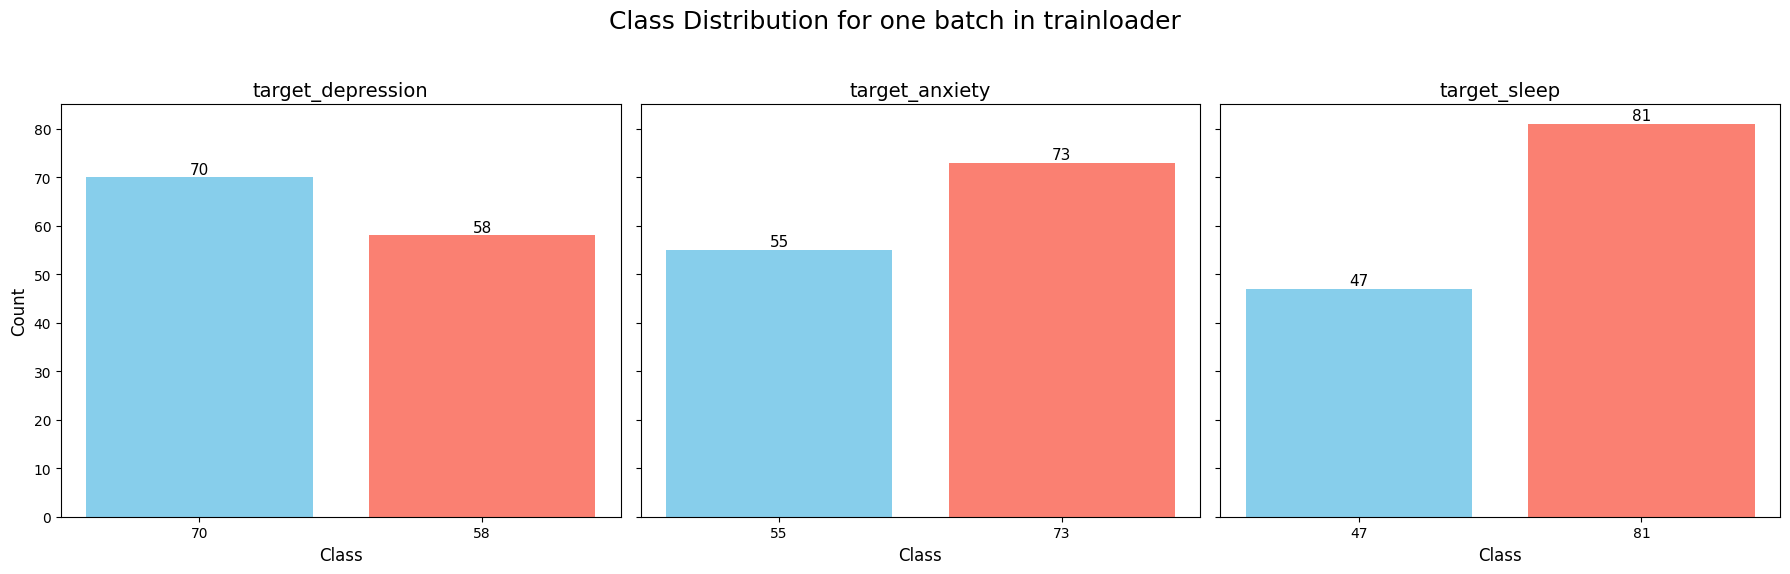

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle('Class Distribution for one batch in trainloader', fontsize=18)

targets = next(iter(train_loader))[1:] # returns list of 3 tensors
for i, target in enumerate(targets):
    counts = np.bincount(target)

    axes[i].bar(counts.astype(str), counts, color=['skyblue', 'salmon'])
    axes[i].set_title(tasks[i], fontsize=14)
    axes[i].set_xlabel('Class', fontsize=12)
    if i == 0:
        axes[i].set_ylabel('Count', fontsize=12)

    for j, count in enumerate(counts):
        axes[i].text(j, count + 0.01 * max(counts), count, ha='center', fontsize=11)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# define model

In [ ]:
class MultiTaskModel(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1)
        )
        self.head1 = nn.Linear(32, 1)  # depression
        self.head2 = nn.Linear(32, 1)  # anxiety
        self.head3 = nn.Linear(32, 1)  # sleep

        with torch.no_grad():
            for i, head in enumerate([self.head1, self.head2, self.head3]):
                p = float(y_train_df[tasks[i]].mean())
                p = np.clip(p, 1e-4, 1-1e-4)
                head.bias.fill_(np.log(p/(1-p)))

    def forward(self, x):
        s = self.shared(x)
        return self.head1(s).squeeze(1), self.head2(s).squeeze(1), self.head3(s).squeeze(1)


# training

In [ ]:
model = MultiTaskModel(in_dim=X_train.shape[1]).to(device)

In [ ]:
def pos_w_from_train(series):
    pos = (series == 1).sum()
    neg = (series == 0).sum()
    pos = max(int(pos), 1)
    return torch.tensor([neg/pos], dtype=torch.float32, device=device)

criterion1 = nn.BCEWithLogitsLoss(pos_weight=pos_w_from_train(y_train_df['target_depression']))
criterion2 = nn.BCEWithLogitsLoss(pos_weight=pos_w_from_train(y_train_df['target_anxiety']))
criterion3 = nn.BCEWithLogitsLoss(pos_weight=pos_w_from_train(y_train_df['target_sleep']))

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
train_losses, val_losses = [], []
train_acc1, train_acc2, train_acc3 = [], [], []
val_acc1,   val_acc2,   val_acc3   = [], [], []

best_val_loss = float('inf')
best_state = None
es_counter = 0

for epoch in range(1, num_epochs+1):
    # ---- Train ----
    model.train()
    run_loss = 0.0
    t_p1, t_p2, t_p3 = [], [], []
    t_y1, t_y2, t_y3 = [], [], []

    for xb, yb1, yb2, yb3 in tqdm(train_loader, leave=False):
        xb = xb.to(device); yb1 = yb1.to(device); yb2 = yb2.to(device); yb3 = yb3.to(device)

        o1, o2, o3 = model(xb)
        loss1 = criterion1(o1, yb1)
        loss2 = criterion2(o2, yb2)
        loss3 = criterion3(o3, yb3)
        loss  = loss1 + lambda_weight * (loss2 + loss3)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
        optimizer.step()

        run_loss += loss.item()
        t_p1.extend((torch.sigmoid(o1) > 0.5).long().cpu().numpy())
        t_p2.extend((torch.sigmoid(o2) > 0.5).long().cpu().numpy())
        t_p3.extend((torch.sigmoid(o3) > 0.5).long().cpu().numpy())
        t_y1.extend(yb1.cpu().numpy()); t_y2.extend(yb2.cpu().numpy()); t_y3.extend(yb3.cpu().numpy())

    tr_loss = run_loss / len(train_loader)
    train_losses.append(tr_loss)
    train_acc1.append(balanced_accuracy_score(t_y1, t_p1))
    train_acc2.append(balanced_accuracy_score(t_y2, t_p2))
    train_acc3.append(balanced_accuracy_score(t_y3, t_p3))

    # ---- Validate ----
    model.eval()
    val_run_loss = 0.0
    v_logits = [[], [], []]
    v_true   = [[], [], []]

    with torch.no_grad():
        for xb, yb1, yb2, yb3 in val_loader:
            xb = xb.to(device); yb1 = yb1.to(device); yb2 = yb2.to(device); yb3 = yb3.to(device)
            o1, o2, o3 = model(xb)
            vl1 = criterion1(o1, yb1); vl2 = criterion2(o2, yb2); vl3 = criterion3(o3, yb3)
            vloss = vl1 + lambda_weight * (vl2 + vl3)
            val_run_loss += vloss.item()

            for i, out in enumerate([o1, o2, o3]):
                v_logits[i].extend(out.cpu().numpy())
            v_true[0].extend(yb1.cpu().numpy()); v_true[1].extend(yb2.cpu().numpy()); v_true[2].extend(yb3.cpu().numpy())

    v_loss = val_run_loss / len(val_loader)
    val_losses.append(v_loss)
    scheduler.step(v_loss)

    # quick BA at p>0.5 (for logging)
    v_ba = []
    for i in range(3):
        probs = 1/(1+np.exp(-np.array(v_logits[i])))
        preds = (probs > 0.5).astype(int)
        v_ba.append(balanced_accuracy_score(v_true[i], preds))
    val_acc1.append(v_ba[0]); val_acc2.append(v_ba[1]); val_acc3.append(v_ba[2])

    print(f"Epoch {epoch:02d} | Train Loss {tr_loss:.4f} | Val Loss {v_loss:.4f} | "
          f"Val BA Dep/Anx/Sleep: {v_ba[0]:.3f}/{v_ba[1]:.3f}/{v_ba[2]:.3f}")

    # early stopping
    if v_loss < best_val_loss - 1e-4:
        best_val_loss = v_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        es_counter = 0
    else:
        es_counter += 1
        if es_counter >= patience:
            print("Early stopping.")
            break

# Load best weights
if best_state is not None:
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

Epoch 01 | Train Loss 2.1865 | Val Loss 2.0939 | Val BA Dep/Anx/Sleep: 0.591/0.588/0.554


Epoch 02 | Train Loss 2.1272 | Val Loss 2.0921 | Val BA Dep/Anx/Sleep: 0.584/0.599/0.566


Epoch 03 | Train Loss 2.1084 | Val Loss 2.0685 | Val BA Dep/Anx/Sleep: 0.597/0.594/0.575


Epoch 04 | Train Loss 2.1010 | Val Loss 2.0419 | Val BA Dep/Anx/Sleep: 0.612/0.598/0.585


Epoch 05 | Train Loss 2.0891 | Val Loss 2.0472 | Val BA Dep/Anx/Sleep: 0.595/0.601/0.593


Epoch 06 | Train Loss 2.0803 | Val Loss 2.0272 | Val BA Dep/Anx/Sleep: 0.612/0.611/0.587


Epoch 07 | Train Loss 2.0767 | Val Loss 2.0185 | Val BA Dep/Anx/Sleep: 0.608/0.611/0.593


Epoch 08 | Train Loss 2.0650 | Val Loss 2.0089 | Val BA Dep/Anx/Sleep: 0.622/0.616/0.597


Epoch 09 | Train Loss 2.0652 | Val Loss 2.0279 | Val BA Dep/Anx/Sleep: 0.607/0.607/0.600


Epoch 10 | Train Loss 2.0524 | Val Loss 2.0001 | Val BA Dep/Anx/Sleep: 0.624/0.618/0.601


Epoch 11 | Train Loss 2.0456 | Val Loss 2.0049 | Val BA Dep/Anx/Sleep: 0.623/0.617/0.595


Epoch 12 | Train Loss 2.0464 | Val Loss 1.9915 | Val BA Dep/Anx/Sleep: 0.625/0.618/0.599


Epoch 13 | Train Loss 2.0421 | Val Loss 1.9936 | Val BA Dep/Anx/Sleep: 0.624/0.619/0.600


Epoch 14 | Train Loss 2.0369 | Val Loss 1.9848 | Val BA Dep/Anx/Sleep: 0.628/0.626/0.603


Epoch 15 | Train Loss 2.0353 | Val Loss 1.9852 | Val BA Dep/Anx/Sleep: 0.622/0.621/0.606


Epoch 16 | Train Loss 2.0313 | Val Loss 1.9808 | Val BA Dep/Anx/Sleep: 0.622/0.621/0.609


Epoch 17 | Train Loss 2.0364 | Val Loss 1.9782 | Val BA Dep/Anx/Sleep: 0.631/0.622/0.605


Epoch 18 | Train Loss 2.0269 | Val Loss 1.9690 | Val BA Dep/Anx/Sleep: 0.633/0.625/0.606


Epoch 19 | Train Loss 2.0208 | Val Loss 1.9676 | Val BA Dep/Anx/Sleep: 0.631/0.631/0.614


Epoch 20 | Train Loss 2.0176 | Val Loss 1.9672 | Val BA Dep/Anx/Sleep: 0.631/0.634/0.602


Epoch 21 | Train Loss 2.0160 | Val Loss 1.9517 | Val BA Dep/Anx/Sleep: 0.643/0.637/0.608


Epoch 22 | Train Loss 2.0153 | Val Loss 1.9622 | Val BA Dep/Anx/Sleep: 0.635/0.632/0.605


Epoch 23 | Train Loss 2.0102 | Val Loss 1.9578 | Val BA Dep/Anx/Sleep: 0.637/0.629/0.606


Epoch 24 | Train Loss 2.0094 | Val Loss 1.9538 | Val BA Dep/Anx/Sleep: 0.639/0.629/0.602


Epoch 25 | Train Loss 2.0065 | Val Loss 1.9485 | Val BA Dep/Anx/Sleep: 0.640/0.637/0.615


Epoch 26 | Train Loss 2.0085 | Val Loss 1.9524 | Val BA Dep/Anx/Sleep: 0.643/0.627/0.612


Epoch 27 | Train Loss 2.0075 | Val Loss 1.9573 | Val BA Dep/Anx/Sleep: 0.639/0.636/0.607


Epoch 28 | Train Loss 2.0034 | Val Loss 1.9581 | Val BA Dep/Anx/Sleep: 0.636/0.630/0.616


Epoch 29 | Train Loss 2.0023 | Val Loss 1.9397 | Val BA Dep/Anx/Sleep: 0.650/0.641/0.608


Epoch 30 | Train Loss 2.0001 | Val Loss 1.9414 | Val BA Dep/Anx/Sleep: 0.652/0.640/0.612


Epoch 31 | Train Loss 1.9975 | Val Loss 1.9474 | Val BA Dep/Anx/Sleep: 0.648/0.633/0.611


Epoch 32 | Train Loss 1.9989 | Val Loss 1.9435 | Val BA Dep/Anx/Sleep: 0.640/0.638/0.613


Epoch 33 | Train Loss 1.9994 | Val Loss 1.9507 | Val BA Dep/Anx/Sleep: 0.642/0.634/0.615


Epoch 34 | Train Loss 1.9938 | Val Loss 1.9394 | Val BA Dep/Anx/Sleep: 0.640/0.638/0.611


Epoch 35 | Train Loss 1.9834 | Val Loss 1.9347 | Val BA Dep/Anx/Sleep: 0.649/0.639/0.617


Epoch 36 | Train Loss 1.9822 | Val Loss 1.9333 | Val BA Dep/Anx/Sleep: 0.649/0.638/0.614


Epoch 37 | Train Loss 1.9860 | Val Loss 1.9252 | Val BA Dep/Anx/Sleep: 0.650/0.644/0.623


Epoch 38 | Train Loss 1.9802 | Val Loss 1.9305 | Val BA Dep/Anx/Sleep: 0.649/0.640/0.616


Epoch 39 | Train Loss 1.9844 | Val Loss 1.9167 | Val BA Dep/Anx/Sleep: 0.657/0.645/0.618


Epoch 40 | Train Loss 1.9720 | Val Loss 1.9192 | Val BA Dep/Anx/Sleep: 0.660/0.643/0.619


# plotting training loss

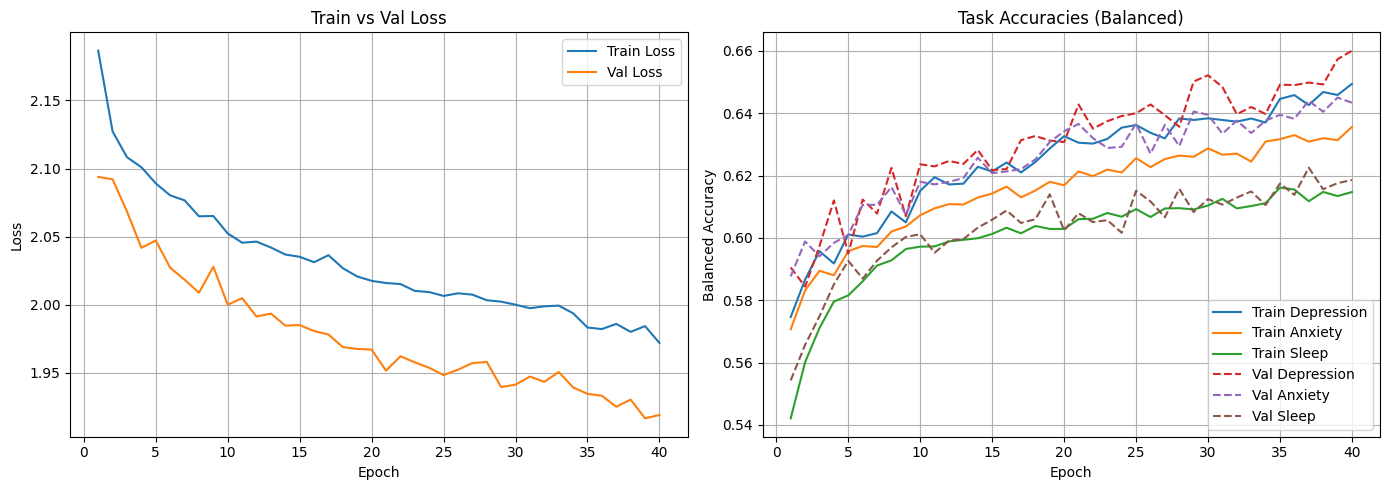

In [ ]:
epochs = range(1, len(train_losses)+1)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(epochs, train_losses, label='Train Loss')
axes[0].plot(epochs, val_losses,   label='Val Loss')
axes[0].set_title('Train vs Val Loss'); axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss')
axes[0].grid(True); axes[0].legend()

axes[1].plot(epochs, train_acc1, label='Train Depression')
axes[1].plot(epochs, train_acc2, label='Train Anxiety')
axes[1].plot(epochs, train_acc3, label='Train Sleep')
axes[1].plot(epochs, val_acc1, '--', label='Val Depression')
axes[1].plot(epochs, val_acc2, '--', label='Val Anxiety')
axes[1].plot(epochs, val_acc3, '--', label='Val Sleep')
axes[1].set_title('Task Accuracies (Balanced)'); axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Balanced Accuracy')
axes[1].grid(True); axes[1].legend()

plt.tight_layout(); plt.show()

In [ ]:
def best_threshold_for_BA(y_true, logits):
    probs = 1.0 / (1.0 + np.exp(-np.array(logits)))
    fpr, tpr, th = roc_curve(y_true, probs)
    j = tpr - fpr
    if len(th) == 0:
        return 0.5
    th_j = th[np.argmax(j)]

    prec, rec, th_pr = precision_recall_curve(y_true, probs)
    if len(th_pr) > 0:
        f1 = (2*prec*rec)/(prec+rec+1e-12)
        th_f1 = th_pr[np.argmax(f1[:-1])]
        return float(np.nan_to_num(th_j, nan=th_f1))
    return float(th_j)

model.eval()
val_logits = [[], [], []]; val_true = [[], [], []]
with torch.no_grad():
    for xb, yb1, yb2, yb3 in val_loader:
        xb = xb.to(device)
        o1, o2, o3 = model(xb)
        for i, out in enumerate([o1, o2, o3]):
            val_logits[i].extend(out.cpu().numpy())
        val_true[0].extend(yb1.numpy()); val_true[1].extend(yb2.numpy()); val_true[2].extend(yb3.numpy())

thr = [best_threshold_for_BA(val_true[i], val_logits[i]) for i in range(3)]
print("Chosen thresholds (Dep/Anx/Sleep):", [round(t, 3) for t in thr])


Chosen thresholds (Dep/Anx/Sleep): [0.578, 0.52, 0.415]



Test Set Metrics (λ = 1.0):

Depression
  Balanced Accuracy: 0.683
  ROC AUC:           0.754
  PR AUC:            0.582

Anxiety
  Balanced Accuracy: 0.652
  ROC AUC:           0.715
  PR AUC:            0.708

Sleep
  Balanced Accuracy: 0.633
  ROC AUC:           0.694
  PR AUC:            0.806


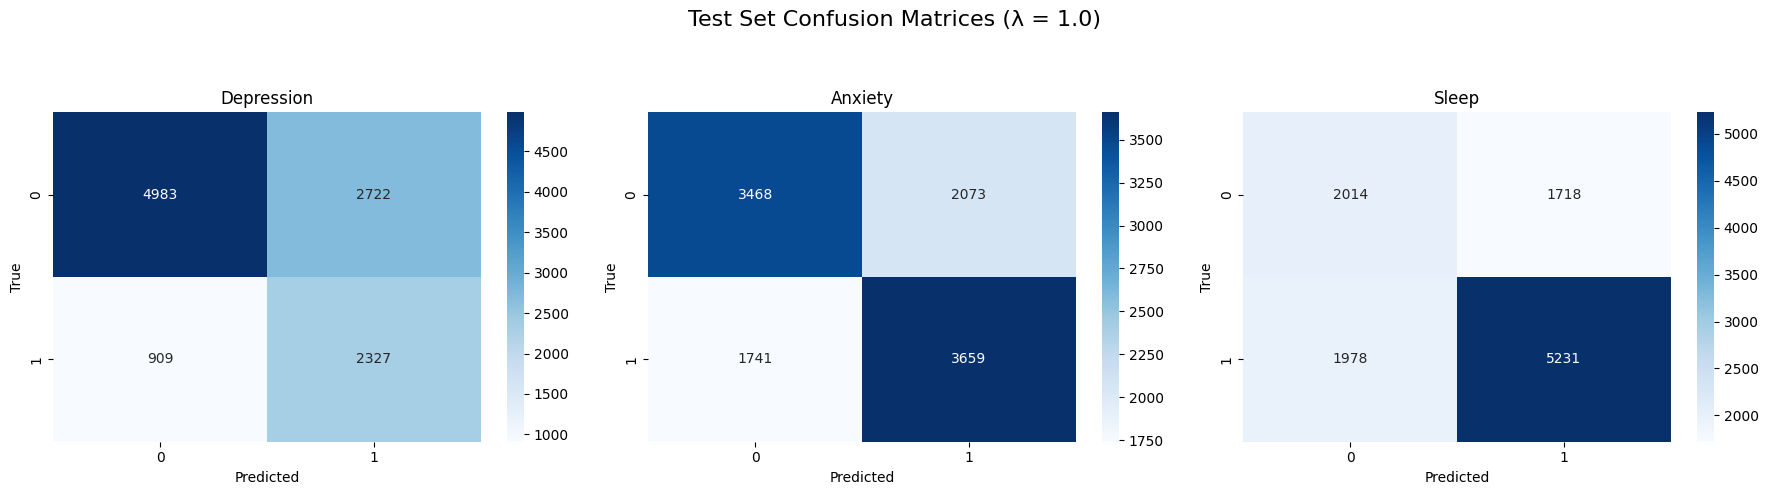

In [ ]:
model.eval()
test_true = [[], [], []]; test_prob = [[], [], []]; test_pred = [[], [], []]
with torch.no_grad():
    for xb, yb1, yb2, yb3 in test_loader:
        xb = xb.to(device)
        o1, o2, o3 = model(xb)
        for i, out in enumerate([o1, o2, o3]):
            p = torch.sigmoid(out).cpu().numpy()
            test_prob[i].extend(p)
            test_pred[i].extend((p > thr[i]).astype(int))
        test_true[0].extend(yb1.numpy()); test_true[1].extend(yb2.numpy()); test_true[2].extend(yb3.numpy())

print(f"\nTest Set Metrics (λ = {lambda_weight}):")
names = ['Depression','Anxiety','Sleep']
for i, name in enumerate(names):
    ba  = balanced_accuracy_score(test_true[i], test_pred[i])
    roc = roc_auc_score(test_true[i], test_prob[i])
    pr  = average_precision_score(test_true[i], test_prob[i])
    print(f"\n{name}")
    print(f"  Balanced Accuracy: {ba:.3f}")
    print(f"  ROC AUC:           {roc:.3f}")
    print(f"  PR AUC:            {pr:.3f}")

# Confusion matrices
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(f'Test Set Confusion Matrices (λ = {lambda_weight})', fontsize=16)
for i, name in enumerate(names):
    cm = confusion_matrix(test_true[i], test_pred[i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[i])
    axs[i].set_title(name); axs[i].set_xlabel('Predicted'); axs[i].set_ylabel('True')
plt.tight_layout(rect=[0, 0, 1, 0.92]); plt.show()